<a href="https://colab.research.google.com/github/debashis-das/cnn_research/blob/main/face_detection_mp_yunet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 32.2 MB/s eta 0:00:00


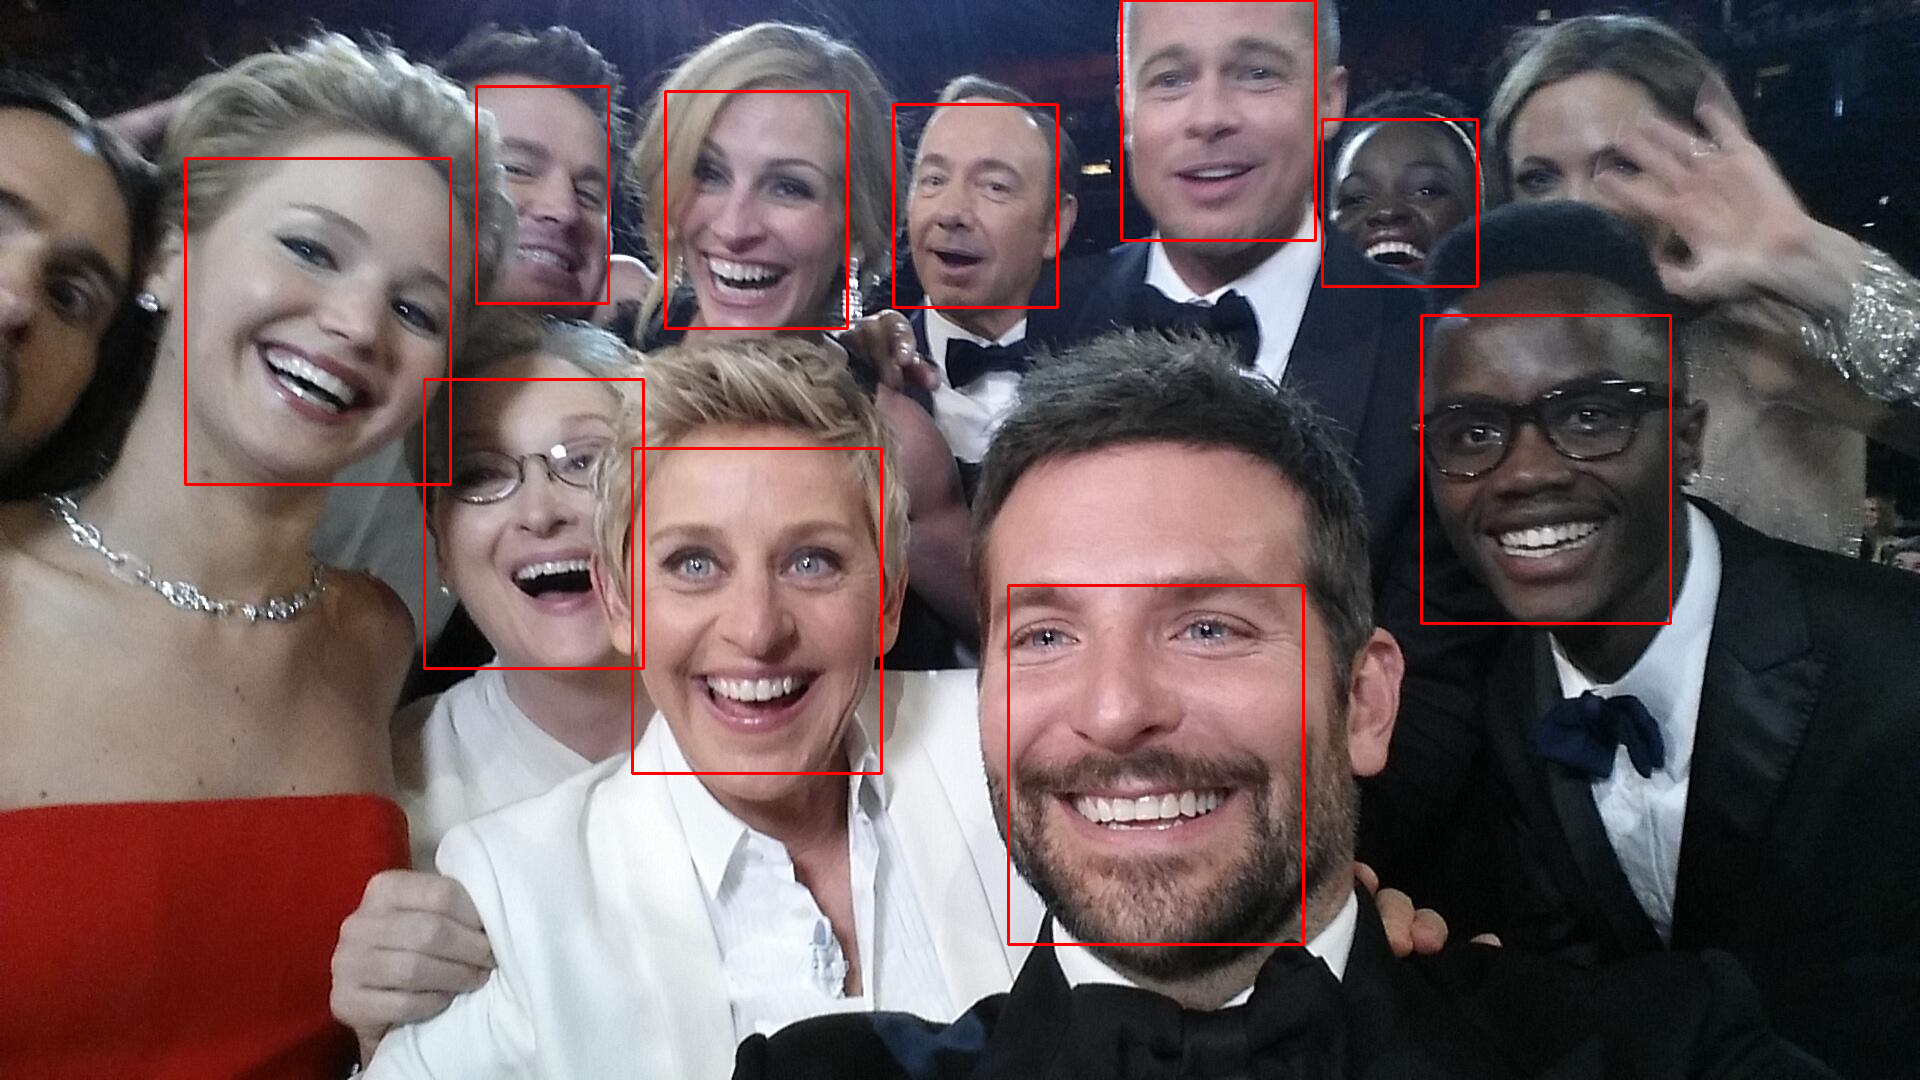

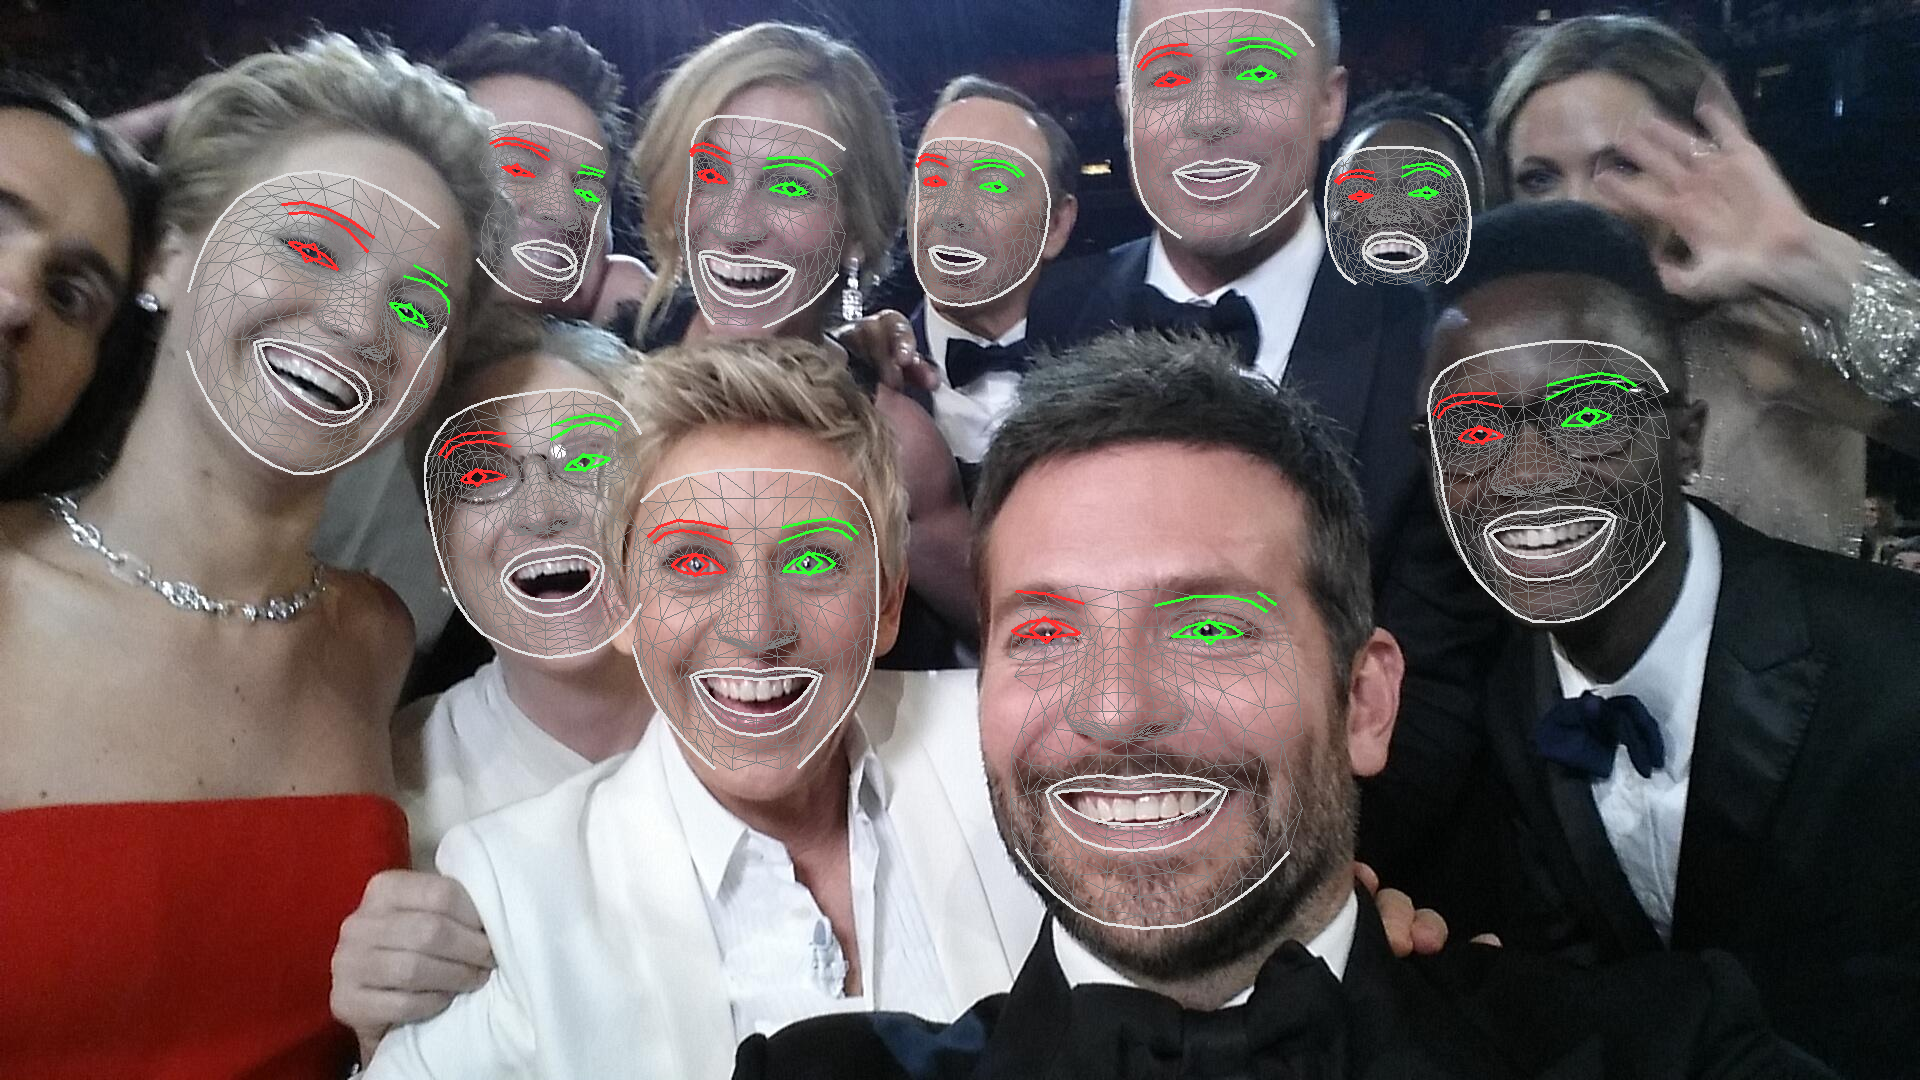

In [8]:
import cv2 as cv
import numpy as np
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from google.colab.patches import cv2_imshow

model = cv.FaceDetectorYN.create(
            model='/content/face_detection_yunet_2022mar.onnx',
            config="",
            input_size=[320, 320],
            score_threshold=0.9,
            nms_threshold=0.3,
            top_k=5000,
            backend_id=3,
            target_id=0)
img = cv.imread('/content/celebrity-selfie.jpg')
# img = cv.imread('/content/gigantic-selfie.jpg')
h, w, _ = img.shape
model.setInputSize((w, h))
faces = model.detect(img)[1]

BaseOptions = mp.tasks.BaseOptions
VisionRunningMode = mp.tasks.vision.RunningMode
faceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions(
        base_options=BaseOptions(model_asset_path='/content/face_landmarker.task'),
        running_mode=VisionRunningMode.IMAGE)

def draw_landmarks_on_image(rgb_image, detection_result):
    face_landmarks_list = detection_result.face_landmarks
    annotated_image = np.copy(rgb_image)
    # Loop through the detected faces to visualize.
    for idx in range(len(face_landmarks_list)):
        face_landmarks = face_landmarks_list[idx]
        if face_landmarks:
            # Draw the face landmarks.
            face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
            face_landmarks_proto.landmark.extend([
                landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
            ])
            solutions.drawing_utils.draw_landmarks(
                image=annotated_image,
                landmark_list=face_landmarks_proto,
                connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp.solutions.drawing_styles
                .get_default_face_mesh_tesselation_style())
            solutions.drawing_utils.draw_landmarks(
                image=annotated_image,
                landmark_list=face_landmarks_proto,
                connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp.solutions.drawing_styles
                .get_default_face_mesh_contours_style())
            solutions.drawing_utils.draw_landmarks(
                image=annotated_image,
                landmark_list=face_landmarks_proto,
                connections=mp.solutions.face_mesh.FACEMESH_IRISES,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp.solutions.drawing_styles
                .get_default_face_mesh_iris_connections_style())

    return annotated_image
output_yunet = img.copy()
output_mp = img.copy()
with mp.tasks.vision.FaceLandmarker.create_from_options(faceLandmarkerOptions) as landmarker:
    for det in (faces if faces is not None else []):
        bbox = det[0:4].astype(np.int32)
        left_x = bbox[0]
        left_y = bbox[1]
        right_x = bbox[0] + bbox[2]
        right_y = bbox[1] + bbox[3]
        face = output_mp[left_y:right_y, left_x:right_x]
        output_yunet = cv.rectangle(output_yunet,(left_x,left_y),(right_x,right_y),(0,0,255),2)
        mp_face = mp.Image(image_format=mp.ImageFormat.SRGB, data=face.copy())
        result = landmarker.detect(mp_face)
        out_face = draw_landmarks_on_image(rgb_image=face, detection_result=result)
        output_mp[left_y:right_y, left_x:right_x] = out_face
    cv2_imshow(output_yunet)
    cv2_imshow(output_mp)